In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brats-2020-slices/slices-20230925T215308Z-001/slices/images/BraTS20_Training_287_slice_88_image.npy
/kaggle/input/brats-2020-slices/slices-20230925T215308Z-001/slices/images/BraTS20_Training_231_slice_55_image.npy
/kaggle/input/brats-2020-slices/slices-20230925T215308Z-001/slices/images/BraTS20_Training_030_slice_77_image.npy
/kaggle/input/brats-2020-slices/slices-20230925T215308Z-001/slices/images/BraTS20_Training_096_slice_89_image.npy
/kaggle/input/brats-2020-slices/slices-20230925T215308Z-001/slices/images/BraTS20_Training_324_slice_32_image.npy
/kaggle/input/brats-2020-slices/slices-20230925T215308Z-001/slices/images/BraTS20_Training_159_slice_72_image.npy
/kaggle/input/brats-2020-slices/slices-20230925T215308Z-001/slices/images/BraTS20_Training_060_slice_46_image.npy
/kaggle/input/brats-2020-slices/slices-20230925T215308Z-001/slices/images/BraTS20_Training_231_slice_107_image.npy
/kaggle/input/brats-2020-slices/slices-20230925T215308Z-001/slices/images/BraTS20_Train

In [2]:
import os
import pandas as pd

# Define the paths to the two slice folders
data_dir1 = '/kaggle/input/brats-2020-slices/slices-20230925T215308Z-001/slices'
data_dir2 = '/kaggle/input/brats-2020-slices/slices-20230925T215308Z-002/slices'

# Get a list of image file names from both folders
image_files1 = os.listdir(os.path.join(data_dir1, 'images'))
image_files2 = os.listdir(os.path.join(data_dir2, 'images'))

# Initialize empty lists to store image and mask paths
image_paths = []
mask_paths = []

# Loop through image files from slices1 and check for corresponding masks
for image_file in image_files1:
    image_path = os.path.join(data_dir1, 'images', image_file)
    mask_file = image_file.replace("_image.npy", "_mask.npy")
    mask_path = os.path.join(data_dir1, 'masks', mask_file)
    
    image_paths.append(image_path)
    # Check if the corresponding mask file exists in slices1->masks
    if os.path.exists(mask_path):
        #image_paths.append(image_path)
        mask_paths.append(mask_path)
    else:
        #image_paths.append(image_path)
        mask_path = os.path.join(data_dir2, 'masks', mask_file)
        mask_paths.append(mask_path)
        

# Loop through image files from slices2 and check for corresponding masks
for image_file in image_files2:
    image_path = os.path.join(data_dir2, 'images', image_file)
    mask_file = image_file.replace("_image.npy", "_mask.npy")
    mask_path = os.path.join(data_dir2, 'masks', mask_file)
    
    image_paths.append(image_path)
    # Check if the corresponding mask file exists in slices2->masks
    if os.path.exists(mask_path):
        #image_paths.append(image_path)
        mask_paths.append(mask_path)
    else:
       # image_paths.append(image_path)
        mask_path = os.path.join(data_dir1, 'masks', mask_file)
        mask_paths.append(mask_path)
        
        

# Create a DataFrame to store the paths
data = pd.DataFrame({'image_path': image_paths, 'mask_path': mask_paths})

In [3]:
# Function to check if a mask has less than 1% positive pixels
import numpy as np
def has_few_positive_pixels(mask_path, threshold=0.05):
    mask = np.load(mask_path)
    positive_pixels = np.sum(mask[:,:,0] > 0)
    total_pixels = mask.size
    return (positive_pixels / total_pixels) < threshold

# Apply the function to the mask_path column
data['has_few_positive_pixels'] = data['mask_path'].apply(has_few_positive_pixels)

# Filter rows based on the condition
data = data[~data['has_few_positive_pixels']]

# Reset the index if needed
data.reset_index(drop=True, inplace=True)

# Remove the temporary column
data.drop('has_few_positive_pixels', axis=1, inplace=True)


In [4]:
data.shape[0]

4866

In [5]:
# Function to plot images and masks
import matplotlib.pyplot as plt
def plot_images_masks(images, masks):
    num_samples = images.shape[0]

    fig, axes = plt.subplots(num_samples, 2, figsize=(10, 10))
    for i in range(num_samples):
        axes[i, 0].imshow(images[i],cmap='bone',interpolation='bicubic')
        axes[i, 0].set_title('Image')
        axes[i, 0].axis('on')

        axes[i, 1].imshow(masks[i],cmap='bone',interpolation='bicubic')
        axes[i, 1].set_title('Mask')
        axes[i, 1].axis('on')

        print(np.max(images[i]),np.max(masks[i]),masks[i].shape)

    plt.tight_layout()
    plt.show()

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


0.977464 1.0 (128, 128, 1)
0.9908923 1.0 (128, 128, 1)
0.9942286 1.0 (128, 128, 1)
0.9968936 1.0 (128, 128, 1)


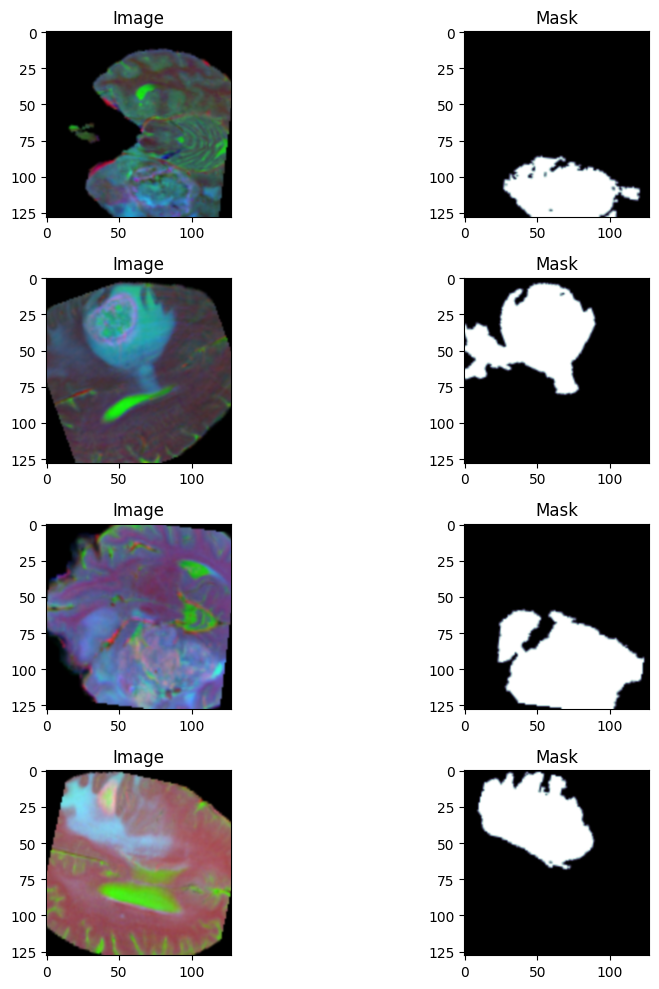

In [6]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define data generator parameters
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='constant'
)

# Function to load and preprocess images and masks
def load_and_preprocess(paths):
    images = []
    masks = []
    for img_path, mask_path in zip(paths['image_path'], paths['mask_path']):
        img = np.load(img_path).astype(np.float32)
        mask = np.load(mask_path).astype(np.float32)
        """mask[:,:,0]=(mask[:,:,0]>0).astype(int)
        mask[:,:,1]=(mask[:,:,1]>0).astype(int)
        mask[:,:,2]=(mask[:,:,2]>0).astype(int)
        new_channel = np.zeros((128, 128, 1), dtype=np.float32)
        mask_4_channel = np.concatenate((new_channel,mask), axis=-1)"""
        mask_=(mask[:,:,0]>0).astype(int)
        mask_=np.expand_dims(mask_,axis=-1)
        
        images.append(img)
        masks.append(mask_)
    return np.array(images), np.array(masks)

# Function to apply augmentations to both images and masks
def apply_augmentation(images, masks):
    seed = np.random.randint(1, 1000)  # Generate a random seed for augmentations
    image_gen = datagen.flow(images, batch_size=len(images), seed=seed)
    mask_gen = datagen.flow(masks, batch_size=len(masks), seed=seed)
    return next(image_gen), next(mask_gen)

# Generate augmented batches of data with synchronized augmentations
def generate_data_generator(data, batch_size):
    while True:
        batch_indices = np.random.choice(len(data), batch_size)
        batch_data = data.iloc[batch_indices]
        x, y = load_and_preprocess(batch_data)
        x_augmented, y_augmented = apply_augmentation(x, y)
        yield x_augmented, y_augmented

# Example usage
batch_size = 4
train_data = generate_data_generator(data, batch_size)

# Plot the batch
batch_images, batch_masks = next(train_data)
plot_images_masks(batch_images, batch_masks)

In [7]:
epsilon = 1e-5
smooth = 1

def iou(targets, inputs, smooth=1e-6):
    
    #flatten label and prediction tensors
    class_num = 2
    for i in range(class_num):
        targets_f= K.flatten(targets[:,:,:,i])
        inputs_f = K.flatten(inputs[:,:,:,i])
       

        intersection = K.sum((targets_f*inputs_f))
        total = K.sum(targets_f) + K.sum(inputs_f)
        union = total - intersection
        loss = (intersection + smooth) / (union + smooth)
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
    return total_loss

def iou_tc(targets, inputs, smooth=1e-6):
    
    #flatten label and prediction tensors
    targets_f = K.flatten(targets[:,:,:,1])
    inputs_f = K.flatten(inputs[:,:,:,1])
    
    intersection = K.sum((targets_f * inputs_f))
    total = K.sum(targets_f) + K.sum(inputs_f)
    union = total - intersection
    
    IoU = (intersection + smooth) / (union + smooth)
    return IoU

def tversky(y_true, y_pred):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def focal_tversky(y_true,y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)

from keras import backend as K

def dice_coeff(y_true, y_pred, smooth=1):
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)
    intersection = K.sum(y_true_flatten * y_pred_flatten)
    dice = (2. * intersection + smooth) / (K.sum(y_true_flatten) + K.sum(y_pred_flatten) + smooth)
    return dice
def dice_loss(y_true, y_pred, smooth=1):
    return  1- dice_coeff(y_true, y_pred, smooth=1)

def FocalLoss(targets, inputs, alpha=0.8, gamma=2):    
    
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)
    
    BCE = K.binary_crossentropy(targets, inputs)
    BCE_EXP = K.exp(-BCE)
    focal_loss = K.mean(alpha * K.pow((1-BCE_EXP), gamma) * BCE)
    
    return focal_loss

def total_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    return dice_loss(y_true, y_pred, smooth=1) + FocalLoss(y_true, y_pred, 0.25,2)

def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    
# Computing Sensitivity      
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


# Computing Specificity
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [8]:
from tensorflow.keras.layers import Conv2D,Conv2DTranspose, BatchNormalization, Activation, MaxPool2D, UpSampling2D, Concatenate, Input, ZeroPadding2D,Dropout,Dense,MaxPooling2D,Reshape,Multiply,GlobalAveragePooling2D,AveragePooling2D,Lambda
from tensorflow.keras.models import Model
from sklearn.decomposition import NMF

def batchnorm_relu(inputs):
    x = BatchNormalization(axis=-1)(inputs)
    x = Activation("relu")(x)
    return x
def ASPP(x, filter):
    shape = x.shape

    y1 = AveragePooling2D(pool_size=(shape[1], shape[2]))(x)
    y1 = Conv2D(filter, 1, padding="same")(y1)
    y1 = BatchNormalization()(y1)
    y1 = Activation("relu")(y1)
    y1 = UpSampling2D((shape[1], shape[2]), interpolation="bilinear")(y1)

    y2 = Conv2D(filter, 1, dilation_rate=1, padding="same", use_bias=False)(x)
    y2 = BatchNormalization()(y2)
    y2 = Activation("relu")(y2)

    y3 = Conv2D(filter, 3, dilation_rate=3, padding="same", use_bias=False)(x)
    y3 = BatchNormalization()(y3)
    y3 = Activation("relu")(y3)

    y4 = Conv2D(filter, 3, dilation_rate=5, padding="same", use_bias=False)(x)
    y4 = BatchNormalization()(y4)
    y4 = Activation("relu")(y4)

    y5 = Conv2D(filter, 3, dilation_rate=7, padding="same", use_bias=False)(x)
    y5 = BatchNormalization()(y5)
    y5 = Activation("relu")(y5)

    y = Concatenate()([y1, y2, y3, y4, y5])

    y = Conv2D(filter, 1, dilation_rate=1, padding="same", use_bias=False)(y)
    y = BatchNormalization()(y)
    y = Activation("relu")(y)

    return y


def SE(input_tensor, ratio=8, i=0):
    
  
    # Compute the global statistics (mean and std deviation) along the channel axis.
    mean = tf.reduce_mean(input_tensor, axis=[1, 2], keepdims=True)
    std = tf.math.reduce_std(input_tensor, axis=[1, 2], keepdims=True)
    
    # Compute channel-wise attention using a convolutional neural network.
    attn_channel = tf.concat([mean, std], axis=-1)
    attn_channel = tf.keras.layers.Conv2D(filters=input_tensor.shape[-1] // ratio, kernel_size=(1, 1), activation='relu',name="first_channel_attention_"+str(i))(attn_channel)
    attn_channel = tf.keras.layers.Conv2D(filters=input_tensor.shape[-1], kernel_size=(1, 1), activation='sigmoid',name="second_channel_attention_"+str(i))(attn_channel)
    
    # Compute spatial attention using global information from the input tensor.
    global_info = tf.reduce_mean(input_tensor, axis=-1, keepdims=True)
    attn_spatial = tf.keras.layers.Conv2D(filters=1, kernel_size=(1, 1), activation='sigmoid',name="spatial_attention_"+str(i))(global_info)
    
    # Combine channel-wise and spatial attention.
    attn = tf.keras.layers.Multiply(name='combined_attention_'+str(i))([attn_channel,attn_spatial])
    
    # Multiply the input tensor by the learned attention weights.
    output_tensor = tf.keras.layers.Multiply(name='SE_out_'+str(i))([input_tensor,attn])
    
    return output_tensor

def residual_block(inputs, num_filters):
    """ Convolutional Layer """
    x = batchnorm_relu(inputs)
    x = Conv2D(num_filters, 3, padding="same", strides=1,kernel_initializer = "he_normal")(x)
    x = Dropout(0.1)(x)
    x = batchnorm_relu(x)
    x = Conv2D(num_filters, 3, padding="same", strides=1,kernel_initializer = "he_normal")(x)
    #x = squeeze_excite_block(x,8)

    """ Shortcut Connection """
    s = Conv2D(num_filters, 1, padding="same", strides=1,kernel_initializer="he_normal")(inputs)
    x = x + s
    return x

def decoder_block(inputs, skip_features, num_filters,i):
    x = Conv2DTranspose(num_filters,2, strides=(2,2), kernel_initializer="he_normal",padding = "same")(inputs)
    x = Concatenate()([x, skip_features])
    x = residual_block(x, num_filters)
    x = SE(x,i=i)
    return x

def build_resunet(input_shape):
    inputs = Input(input_shape)
    
    #integrating augmentation directly into the model
    #x = tf.keras.layers.RandomContrast(0.15)(inputs)
    #x = tf.keras.layers.RandomTranslation(height_factor=0.2, width_factor=0.2)(x)
    #x = tf.keras.layers.RandomFlip("horizontal_and_vertical")(x)
    #x_ = tf.keras.layers.RandomZoom(0.3)(x)
    
   

    

    """ Encoder 1 """
    x = Conv2D(32, 3, padding="same", strides=1,kernel_initializer="he_normal")(inputs)
    x = batchnorm_relu(x)
    x = Conv2D(32, 3, padding="same", strides=1,kernel_initializer="he_normal")(x)
    s = Conv2D(32, 1, padding="same", strides=1,kernel_initializer="he_normal")(inputs)
    
    c1 = x + s
    c1 =SE(c1,i=1)
    p1 = MaxPooling2D((2,2))(c1)
    #s1 = residual_block(c1,32)
    s1 = c1

    """ Encoder 2 and 3 """
    c2 = residual_block(p1, 64)
    c2 = SE(c2,i=2)
    p2 = MaxPooling2D((2,2))(c2)
    #s2 = residual_block(c2,64)
    s2 = c2
    
    c3 = residual_block(p2, 128)
    c3 =SE(c3,i=4)
    p3 = MaxPooling2D((2,2))(c3)
    #s3 = residual_block(c3,128)
    s3 = c3

    c4 = residual_block(p3, 256)
    c4 = SE(c4,i=5)
    p4 = MaxPooling2D((2,2))(c4)
    #s4 = residual_block(c4,256)
    s4 = c4

    """ Bridge """
    b = ASPP(p4,256)
    #b = p4

    """ Decoder 1, 2, 3 """
    d1 = decoder_block(b, s4, 256,i=6)
    d2 = decoder_block(d1, s3, 128,i=7)
    d3 = decoder_block(d2, s2, 64,i=8)
    d4 = decoder_block(d3, s1, 32,i=9)

    """ Classifier """
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    """ Model """
    model = Model(inputs, outputs)
    return model

In [9]:
!pip3 install -U segmentation-models
%env SM_FRAMEWORK=tf.keras
import segmentation_models as sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 892.3 kB/s eta 0:00:00
env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.


In [10]:
# compling model and callbacks functions
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from keras.callbacks import CSVLogger
model = build_resunet((128,128,3))
adam = tf.keras.optimizers.Adam(learning_rate = 0.0001)
model.compile(optimizer = adam, 
                  loss = total_loss, 
                  metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5),dice_coeff,precision,sensitivity,specificity,tf.keras.metrics.AUC()]
                 )
#callbacks
csv_logger = CSVLogger('/kaggle/working/training_log_wt', separator=',', append=False)
earlystopping = EarlyStopping(monitor='val_loss',
                              mode='min', 
                              verbose=1, 
                              patience=8
                             )
# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="/kaggle/working/seg_model_wt.h5", 
                               verbose=1, 
                               save_best_only=True,
                               save_weights_only=True
                              )
                              
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=4,
                              min_delta=0.000001,
                              factor=0.2
                             )
callbacks = [checkpointer, reduce_lr, csv_logger]

In [11]:
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

# Define batch size
batch_size = 8

# Create data generators for training and validation sets
train_generator = generate_data_generator(train_data, batch_size)
val_generator = generate_data_generator(val_data, batch_size)

train_steps_per_epoch = len(train_data) // batch_size
val_steps_per_epoch = len(val_data) // batch_size


In [12]:
history = model.fit(train_generator, 
                  steps_per_epoch=train_steps_per_epoch,
                  epochs = 50, 
                  validation_data = val_generator,
                  validation_steps=val_steps_per_epoch,
                  callbacks = callbacks
                 )

Epoch 1/50


2023-12-28 20:03:42.445987: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


486/486 [==============================] - ETA: 0s - loss: 0.1315 - iou_score: 0.8614 - f1-score: 0.9149 - dice_coeff: 0.8792 - precision: 0.8954 - sensitivity: 0.9303 - specificity: 0.9673 - auc: 0.9865
Epoch 1: val_loss improved from inf to 0.13612, saving model to /kaggle/working/seg_model_wt.h5
486/486 [==============================] - 99s 115ms/step - loss: 0.1315 - iou_score: 0.8614 - f1-score: 0.9149 - dice_coeff: 0.8792 - precision: 0.8954 - sensitivity: 0.9303 - specificity: 0.9673 - auc: 0.9865 - val_loss: 0.1361 - val_iou_score: 0.8291 - val_f1-score: 0.9062 - val_dice_coeff: 0.9027 - val_precision: 0.9237 - val_sensitivity: 0.8866 - val_specificity: 0.9824 - val_auc: 0.9656 - lr: 1.0000e-04
Epoch 2/50
486/486 [==============================] - ETA: 0s - loss: 0.0407 - iou_score: 0.9412 - f1-score: 0.9695 - dice_coeff: 0.9652 - precision: 0.9667 - sensitivity: 0.9674 - specificity: 0.9919 - auc: 0.9942
Epoch 2: val_loss improved from 0.13612 to 0.12311, saving model to /kag

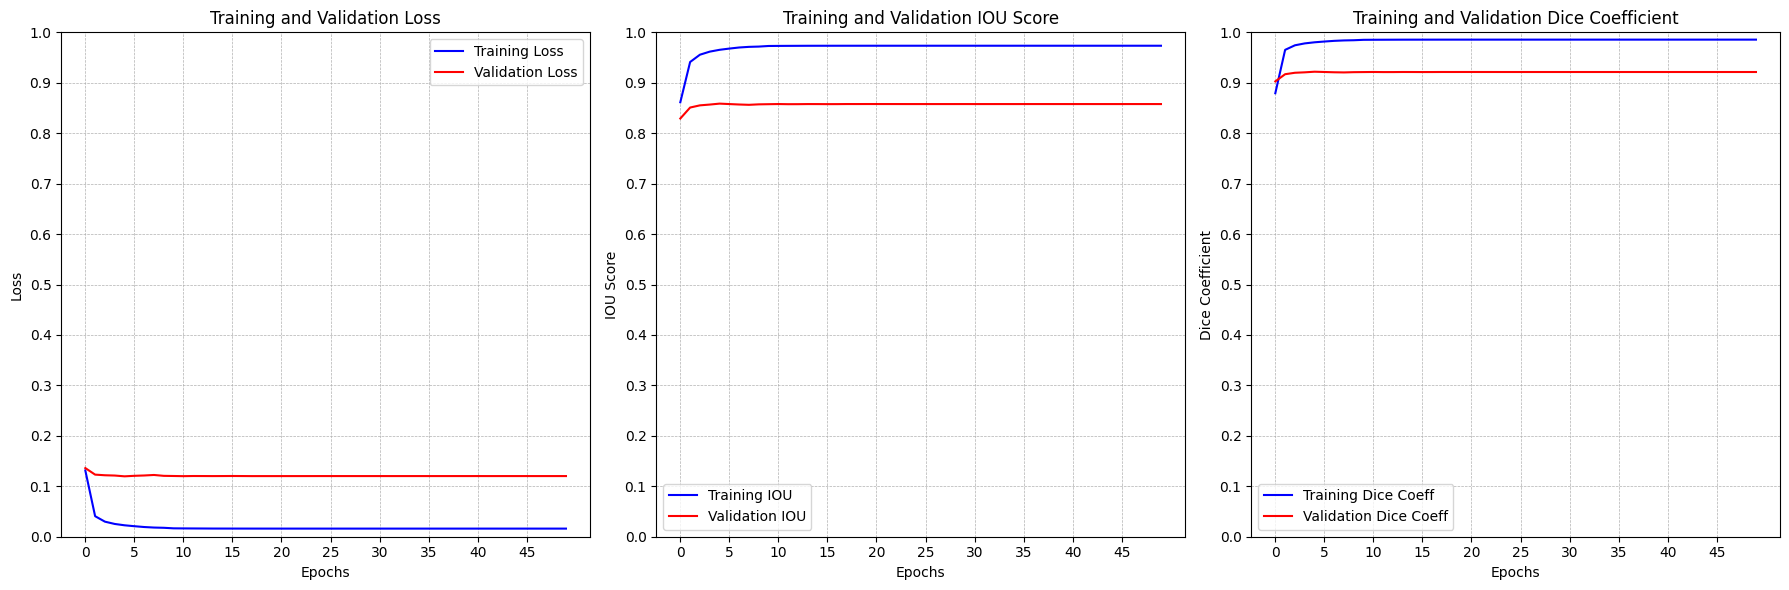

In [13]:
history = pd.read_csv('/kaggle/working/training_log_wt', sep=',', engine='python')

#hist=history.history

############### ########## ####### #######

iou_score=history['iou_score']
val_iou_score=history['val_iou_score']

loss=history['loss']
val_loss=history['val_loss']

train_dice=history['dice_coeff']
val_dice=history['val_dice_coeff']

epoch = np.arange(len(loss))

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
plt.subplots_adjust(wspace=0.3)  # Adjust the space between subplots

# Plot 1: Loss
axes[0].plot(epoch, loss, 'b', label='Training Loss', linewidth=1.5)
axes[0].plot(epoch, val_loss, 'r', label='Validation Loss', linewidth=1.5)
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()

# Plot 2: IOU Scores
axes[1].plot(epoch, iou_score, 'b', label='Training IOU', linewidth=1.5)
axes[1].plot(epoch, val_iou_score, 'r', label='Validation IOU', linewidth=1.5)
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('IOU Score')
axes[1].set_title('Training and Validation IOU Score')
axes[1].legend()

# Plot 3: Dice Coefficients
axes[2].plot(epoch, train_dice, 'b', label='Training Dice Coeff', linewidth=1.5)
axes[2].plot(epoch, val_dice, 'r', label='Validation Dice Coeff', linewidth=1.5)
axes[2].set_xlabel('Epochs')
axes[2].set_ylabel('Dice Coefficient')
axes[2].set_title('Training and Validation Dice Coefficient')
axes[2].legend()

# Customize tick marks and labels
for ax in axes:
    ax.grid(True)
    ax.set_xticks(np.arange(0, len(epoch), 5))  # Adjust the x-axis ticks
    ax.set_yticks(np.arange(0, 1.1, 0.1))  # Adjust the y-axis ticks
    ax.grid(which='both', linestyle='--', linewidth=0.5)

# Display the plots
plt.tight_layout()
plt.show()
